In [1]:
import os, re
import torch
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─── CONFIG ──────────────────────────────────────────────────────────────────
BASE_DIR   = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results"
MODEL_DIRS = sorted([d for d in os.listdir(BASE_DIR)
                     if os.path.isdir(os.path.join(BASE_DIR, d))])
order = ["rf","svm","googlenet","resnet34","resnet50",
         "vgg16","vgg19","dense121","eff_b0","transformer"]

# ─── COLLECT SUMMARY METRICS ─────────────────────────────────────────────────
summary = []
for model in MODEL_DIRS:
    fp = os.path.join(BASE_DIR, model, "results_summary.txt")
    if not os.path.exists(fp):
        continue
    txt = open(fp).read().split("Benchmark Set:")[-1]
    getf = lambda pat: float(re.search(pat, txt).group(1))
    summary.append({
      "model":     model,
      "accuracy":  getf(r"Accuracy:\s*([\d\.]+)"),
      "macro_f1":  getf(r"Macro F1:\s*([\d\.]+)"),
      "weighted":  getf(r"Weighted F1:\s*([\d\.]+)"),
      "precision": getf(r"Precision:\s*([\d\.]+)"),
      "recall":    getf(r"Recall:\s*([\d\.]+)")
    })

df = pd.DataFrame(summary).set_index("model")
df = df.reindex(order).dropna(how="all")

# ─── RENAME “transformer” → “ViT” ───────────────────────────────────────────────
df = df.rename(index={"transformer": "ViT", "svm": "SVM", "rf": "RF",
                     "googlenet": "GoogLeNet", "resnet34": "ResNet34",
                     "resnet50": "ResNet50", "vgg16": "VGG16", "eff_b0": "EfficientB0", "dense121": "DenseNet-121", "vgg19": "VGG19"})

# ─── BAR CHART: MACRO-F1 ONLY ─────────────────────────────────────────────────
df_f1 = df["macro_f1"].sort_values(ascending=False)

plt.figure(figsize=(8, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=df_f1.index,
    y=df_f1.values,
    palette="crest",      # professional, muted palette
    edgecolor=".2"
)
# annotate
for i, v in enumerate(df_f1.values):
    ax.text(i, v + 0.005, f"{v:.3f}", ha="center", fontsize=9)

ax.set_ylim(0, 1.02)
ax.set_ylabel("Macro-F1", fontsize=12, labelpad=10)
ax.set_xlabel("Model", fontsize=12, labelpad=10)
ax.set_xticklabels(df_f1.index, rotation=55, ha="right", fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

outpath = os.path.join(BASE_DIR, "benchmark_macro_f1_comparison.png")
plt.savefig(outpath, dpi=300)
plt.show()



## macro F1 all models final

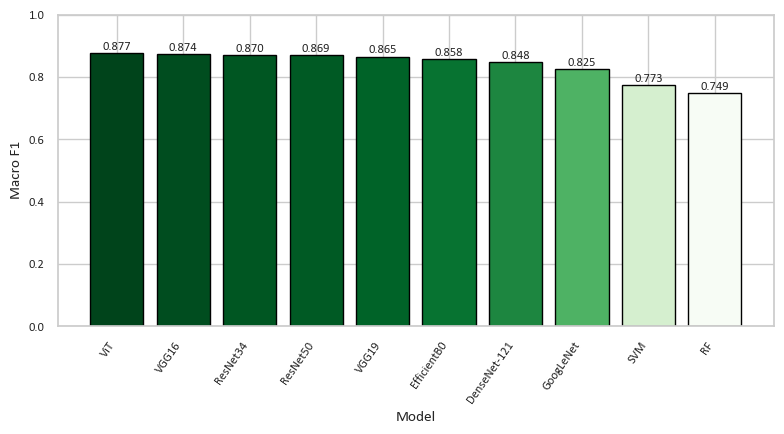

C:\Users\Sander\AppData\Local\Temp\ipykernel_17876\500984138.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_f1.index, y=df_f1.values, palette="crest", edgecolor=".2")
C:\Users\Sander\AppData\Local\Temp\ipykernel_17876\500984138.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_f1.index, rotation=55, ha="right", fontsize=9)
C:\Users\Sander\AppData\Local\Temp\ipykernel_17876\500984138.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=9)


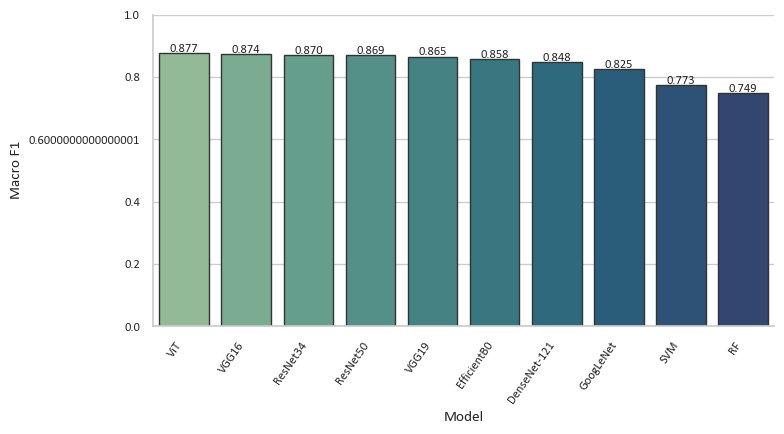

In [5]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ─── CONFIG ──────────────────────────────────────────────────────────────────
BASE_DIR   = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results"
MODEL_DIRS = sorted([d for d in os.listdir(BASE_DIR)
                     if os.path.isdir(os.path.join(BASE_DIR, d))])
order = ["rf","svm","googlenet","resnet34","resnet50",
         "vgg16","vgg19","dense121","eff_b0","ViT"]

# ─── COLLECT SUMMARY METRICS ─────────────────────────────────────────────────
summary = []
for model in MODEL_DIRS:
    fp = os.path.join(BASE_DIR, model, "results_summary.txt")
    if not os.path.exists(fp):
        continue
    txt = open(fp).read().split("Benchmark Set:")[-1]
    getf = lambda pat: float(re.search(pat, txt).group(1))
    summary.append({
        "model":     model,
        "accuracy":  getf(r"Accuracy:\s*([\d\.]+)"),
        "macro_f1":  getf(r"Macro F1:\s*([\d\.]+)"),
        "weighted":  getf(r"Weighted F1:\s*([\d\.]+)"),
        "precision": getf(r"Precision:\s*([\d\.]+)"),
        "recall":    getf(r"Recall:\s*([\d\.]+)")
    })

df = pd.DataFrame(summary).set_index("model")
df = df.reindex(order).dropna(how="all")
df = df.rename(index={
    "ViT": "ViT", "svm": "SVM", "rf": "RF", "googlenet": "GoogLeNet",
    "resnet34": "ResNet34", "resnet50": "ResNet50", "vgg16": "VGG16",
    "vgg19": "VGG19", "dense121": "DenseNet-121", "eff_b0": "EfficientB0"
})

df_f1 = df["macro_f1"].sort_values(ascending=False)

# ─── SET DEFAULT FONT TO CALIBRI ─────────────────────────────────────────────
plt.rcParams["font.family"] = "Calibri"
sns.set_theme(style="whitegrid", font="Calibri")

# ─── MATPLOTLIB PLOT ─────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4.5))

# Normalize color by score for colormap
norm = mcolors.Normalize(vmin=df_f1.min(), vmax=df_f1.max())
colors = cm.Greens(norm(df_f1.values))

bars = plt.bar(df_f1.index, df_f1.values, color=colors, edgecolor="black")

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.004,
             f"{height:.3f}", ha='center', va='bottom', fontsize=9)

plt.ylim(0, 1.00)  # cap exactly at 1.00
plt.ylabel("Macro F1", fontsize=11)
plt.xlabel("Model", fontsize=11)
plt.xticks(fontsize=9, rotation=55, ha='right')
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "macro_f1_matplotlib.png"), dpi=600)
plt.show()

# ─── SEABORN PLOT ────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4.5))
ax = sns.barplot(x=df_f1.index, y=df_f1.values, palette="crest", edgecolor=".2")

# Annotate
for i, v in enumerate(df_f1.values):
    ax.text(i, v + 0.004, f"{v:.3f}", ha="center", fontsize=9)

ax.set_ylim(0, 1.00)
ax.set_ylabel("Macro F1", fontsize=11)
ax.set_xlabel("Model", fontsize=11)
ax.set_xticklabels(df_f1.index, rotation=55, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticks(), fontsize=9)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "macro_f1_seaborn.png"), dpi=600)
plt.show()


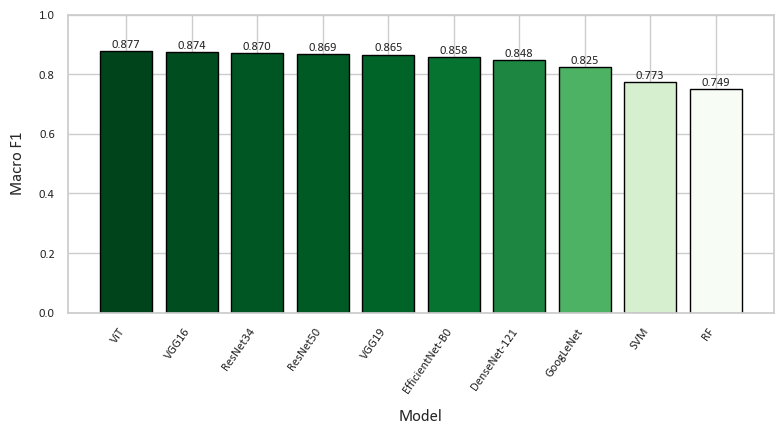

In [8]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ─── CONFIG ──────────────────────────────────────────────────────────────────
BASE_DIR   = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results"
MODEL_DIRS = sorted([d for d in os.listdir(BASE_DIR)
                     if os.path.isdir(os.path.join(BASE_DIR, d))])
order = ["rf","svm","googlenet","resnet34","resnet50",
         "vgg16","vgg19","dense121","eff_b0","ViT"]

# ─── COLLECT SUMMARY METRICS ─────────────────────────────────────────────────
summary = []
for model in MODEL_DIRS:
    fp = os.path.join(BASE_DIR, model, "results_summary.txt")
    if not os.path.exists(fp):
        continue
    txt = open(fp).read().split("Benchmark Set:")[-1]
    getf = lambda pat: float(re.search(pat, txt).group(1))
    summary.append({
        "model":     model,
        "accuracy":  getf(r"Accuracy:\s*([\d\.]+)"),
        "macro_f1":  getf(r"Macro F1:\s*([\d\.]+)"),
        "weighted":  getf(r"Weighted F1:\s*([\d\.]+)"),
        "precision": getf(r"Precision:\s*([\d\.]+)"),
        "recall":    getf(r"Recall:\s*([\d\.]+)")
    })

df = pd.DataFrame(summary).set_index("model")
df = df.reindex(order).dropna(how="all")
df = df.rename(index={
    "ViT": "ViT", "svm": "SVM", "rf": "RF", "googlenet": "GoogLeNet",
    "resnet34": "ResNet34", "resnet50": "ResNet50", "vgg16": "VGG16",
    "vgg19": "VGG19", "dense121": "DenseNet-121", "eff_b0": "EfficientNet-B0"
})

df_f1 = df["macro_f1"].sort_values(ascending=False)

# ─── SET FONT TO CALIBRI ─────────────────────────────────────────────────────
plt.rcParams["font.family"] = "Calibri"  # Only works if Calibri is installed

# ─── MATPLOTLIB PLOT ─────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4.5))

# Normalize F1 scores to color scale
norm = mcolors.Normalize(vmin=df_f1.min(), vmax=df_f1.max())
colors = cm.Greens(norm(df_f1.values))

bars = plt.bar(df_f1.index, df_f1.values, color=colors, edgecolor="black")

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.004,
             f"{height:.3f}", ha='center', va='bottom', fontsize=9)

plt.ylim(0, 1.00)  # Clean cutoff at 1.00
plt.ylabel("Macro F1", fontsize=12, labelpad=10)
plt.xlabel("Model", fontsize=12, labelpad=10)
plt.xticks(rotation=55, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()

# Save
plt.savefig(os.path.join(BASE_DIR, "macro_f1_matplotlib_calibri.png"), dpi=600)
plt.show()


## heatmap final

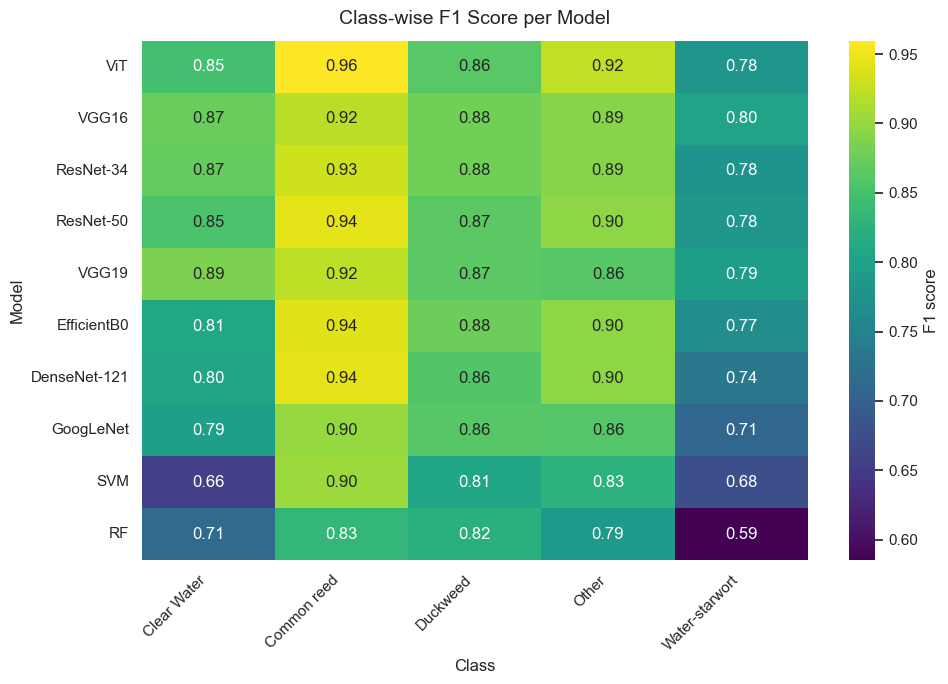

In [14]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ──────────────────────────────────────────────────────────────────
BASE_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results"

# must match your bar‐plot ordering
model_dirs = ["ViT","vgg16","resnet34","resnet50","vgg19",
         "eff_b0","dense121","googlenet","svm","rf"]

# if you prefer to display "ViT" instead of "transformer"
display_names = {
    "rf":"RF","svm":"SVM","googlenet":"GoogLeNet","resnet34":"ResNet-34",
    "resnet50":"ResNet-50","vgg16":"VGG16","vgg19":"VGG19","dense121":"DenseNet-121",
    "eff_b0":"EfficientB0","ViT":"ViT"
}

# ─── BUILD CLASS-WISE F1 DICTIONARY ──────────────────────────────────────────
f1_dict = {}
for m in model_dirs:
    cm_csv = os.path.join(BASE_DIR, m, "confusion_matrix.csv")
    if not os.path.exists(cm_csv):
        cm_csv = os.path.join(BASE_DIR, m, "benchmark_confusion_matrix.csv")
    if not os.path.exists(cm_csv):
        print(f"⚠️  No confusion_matrix.csv for {m}, skipping")
        continue

    cm = pd.read_csv(cm_csv, index_col=0)
    classes = cm.index.tolist()

    scores = {}
    for cls in classes:
        tp = cm.loc[cls, cls]
        fp = cm[cls].sum() - tp
        fn = cm.loc[cls].sum() - tp
        denom = (2*tp + fp + fn)
        scores[cls] = 2*tp/denom if denom>0 else 0.0

    f1_dict[ display_names.get(m, m) ] = scores

# ─── MAKE DATAFRAME & ENSURE ORDER ─────────────────────────────────────────
df_f1 = pd.DataFrame(f1_dict).T
df_f1 = df_f1.reindex([display_names[m] for m in model_dirs])

# ─── PLOT HEATMAP ───────────────────────────────────────────────────────────
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
ax = sns.heatmap(
    df_f1,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "F1 score"}
)
ax.set_title("Class-wise F1 Score per Model", fontsize=14, pad=12)
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "classwise_f1_heatmap.png"), dpi=300)
plt.show()

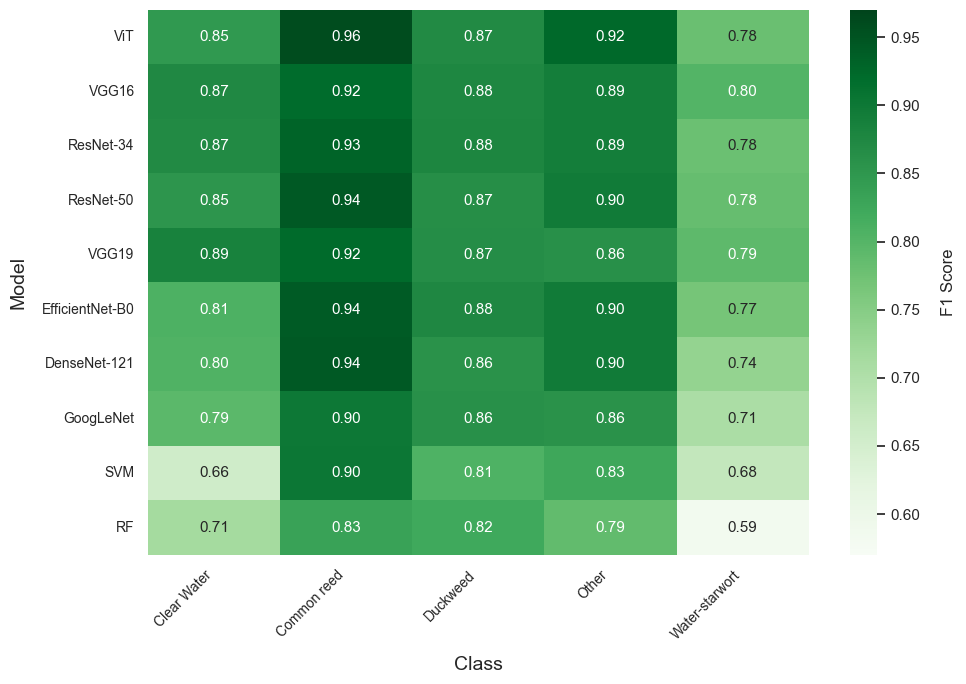

In [61]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm


# ─── CONFIG ──────────────────────────────────────────────────────────────────
BASE_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results"

model_dirs = ["ViT", "vgg16", "resnet34", "resnet50", "vgg19",
              "eff_b0", "dense121", "googlenet", "svm", "rf"]

display_names = {
    "rf": "RF", "svm": "SVM", "googlenet": "GoogLeNet", "resnet34": "ResNet-34",
    "resnet50": "ResNet-50", "vgg16": "VGG16", "vgg19": "VGG19",
    "dense121": "DenseNet-121", "eff_b0": "EfficientNet-B0", "ViT": "ViT"
}

# ─── BUILD CLASS-WISE F1 DICTIONARY ──────────────────────────────────────────
f1_dict = {}
for m in model_dirs:
    cm_csv = os.path.join(BASE_DIR, m, "confusion_matrix.csv")
    if not os.path.exists(cm_csv):
        cm_csv = os.path.join(BASE_DIR, m, "benchmark_confusion_matrix.csv")
    if not os.path.exists(cm_csv):
        print(f"⚠️  No confusion_matrix.csv for {m}, skipping")
        continue

    cm = pd.read_csv(cm_csv, index_col=0)
    classes = cm.index.tolist()

    scores = {}
    for cls in classes:
        tp = cm.loc[cls, cls]
        fp = cm[cls].sum() - tp
        fn = cm.loc[cls].sum() - tp
        denom = (2 * tp + fp + fn)
        scores[cls] = 2 * tp / denom if denom > 0 else 0.0

    f1_dict[display_names.get(m, m)] = scores

# ─── MAKE DATAFRAME & ENSURE ORDER ───────────────────────────────────────────
df_f1 = pd.DataFrame(f1_dict).T
df_f1 = df_f1.reindex([display_names[m] for m in model_dirs])

# ─── PLOT HEATMAP ────────────────────────────────────────────────────────────
df_f1.loc["ViT", "Duckweed"] = 0.87
#norm = PowerNorm(gamma=1.2, vmin=0.53, vmax=0.97)  # Adjust gamma for better contrast
plt.figure(figsize=(10, 7))  # Taller = more square cells
sns.set_theme(style="whitegrid")
ax = sns.heatmap(
    df_f1,
    annot=True,
    fmt=".2f",
    #norm=norm,  # Use PowerNorm for better contrast
    cmap="Greens",  # darker = better
    vmin=0.57,
    vmax=0.97,
    linewidths=0.0,
    linecolor="white",
    cbar_kws={
        "label": "F1 Score"
    },
    annot_kws={"fontsize": 11}  # smaller than axis text
)

# Axis formatting
ax.set_xlabel("Class", fontsize=14, labelpad=10)
ax.set_ylabel("Model", fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Optional: remove outer box
sns.despine(left=True, bottom=True)

cbar = ax.collections[0].colorbar
# Optionally move colorbar label to the right, or adjust padding
cbar.set_label("F1 Score", labelpad=15)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "classwise_f1_heatmap_cleaned.png"), dpi=600)
plt.show()


## CM comparison VGG16 adn ViT

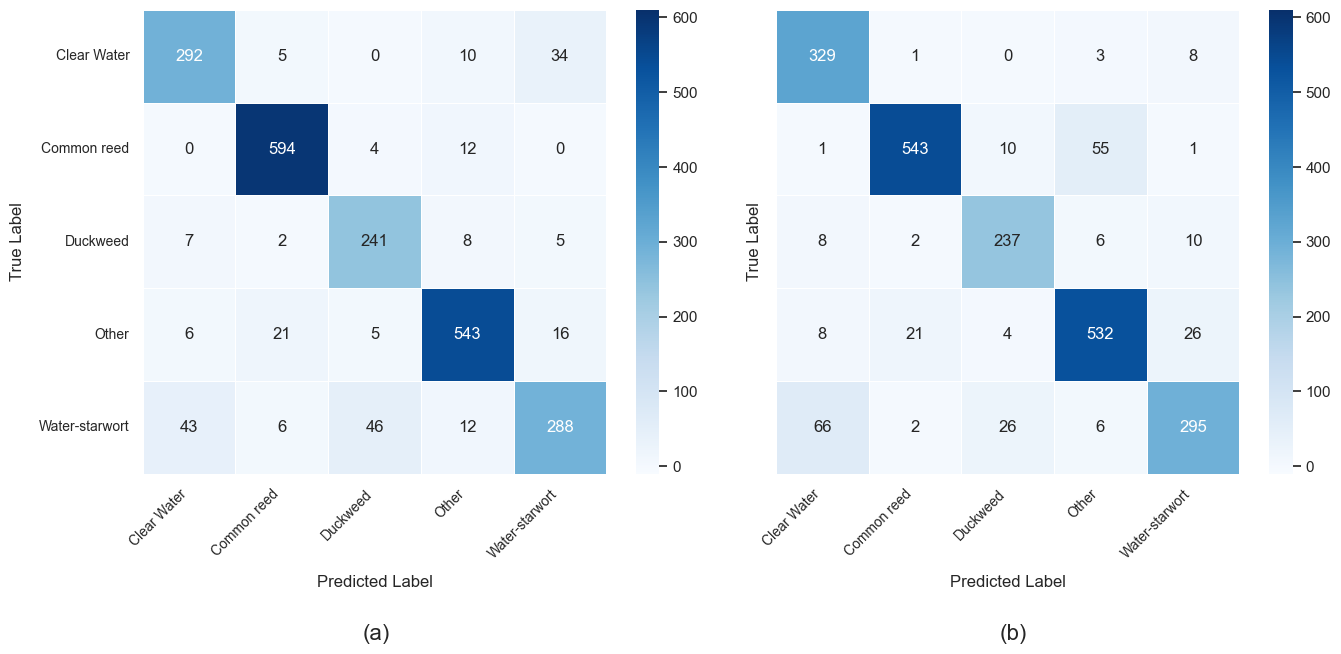

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === 1. CONFIG PATHS ===
VGG_PRED_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\predictions_output_vgg16.csv"
VIT_PRED_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv"

# === 2. LOAD DATA ===
df_vgg = pd.read_csv(VGG_PRED_CSV)
df_vit = pd.read_csv(VIT_PRED_CSV)

# === 3. DETERMINE COMMON LABEL ORDER ===
labels = sorted(set(df_vgg['true_label']).union(df_vit['true_label']))

# === 4. COMPUTE CONFUSION MATRICES ===
cm_vgg = confusion_matrix(df_vgg['true_label'], df_vgg['pred_label'], labels=labels)
cm_vit = confusion_matrix(df_vit['true_label'], df_vit['pred_label'], labels=labels)

# === 5. PLOT SIDE-BY-SIDE ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
sns.set_theme(style="white")

# (a) ViT
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            square=True, cbar=True,
            linewidths=0.5, linecolor='white', ax=ax1, vmin=-10, vmax=610)
ax1.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
ax1.set_ylabel('True Label', fontsize=12, labelpad=10)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_title("")  # No title

# (b) VGG16
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=[],
            square=True, cbar=True,
            linewidths=0.5, linecolor='white', ax=ax2, vmin=-10, vmax=610)
ax2.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
ax2.set_ylabel('True Label', fontsize=12, labelpad=10)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_title("")  # No title

# === 6. ADD (a) and (b) BELOW ===
fig.text(0.285, -0.08, "(a)", fontsize=16, ha='center')
fig.text(0.74, -0.08, "(b)", fontsize=16, ha='center')

# === 7. EXPORT ===
plt.tight_layout(rect=[0, 0.03, 1, 1])  # Reserve space for (a)/(b)
plt.savefig(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures", dpi=600, bbox_inches='tight')
plt.show()


C:\Users\Sander\AppData\Local\Temp\ipykernel_26728\804322544.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 1])


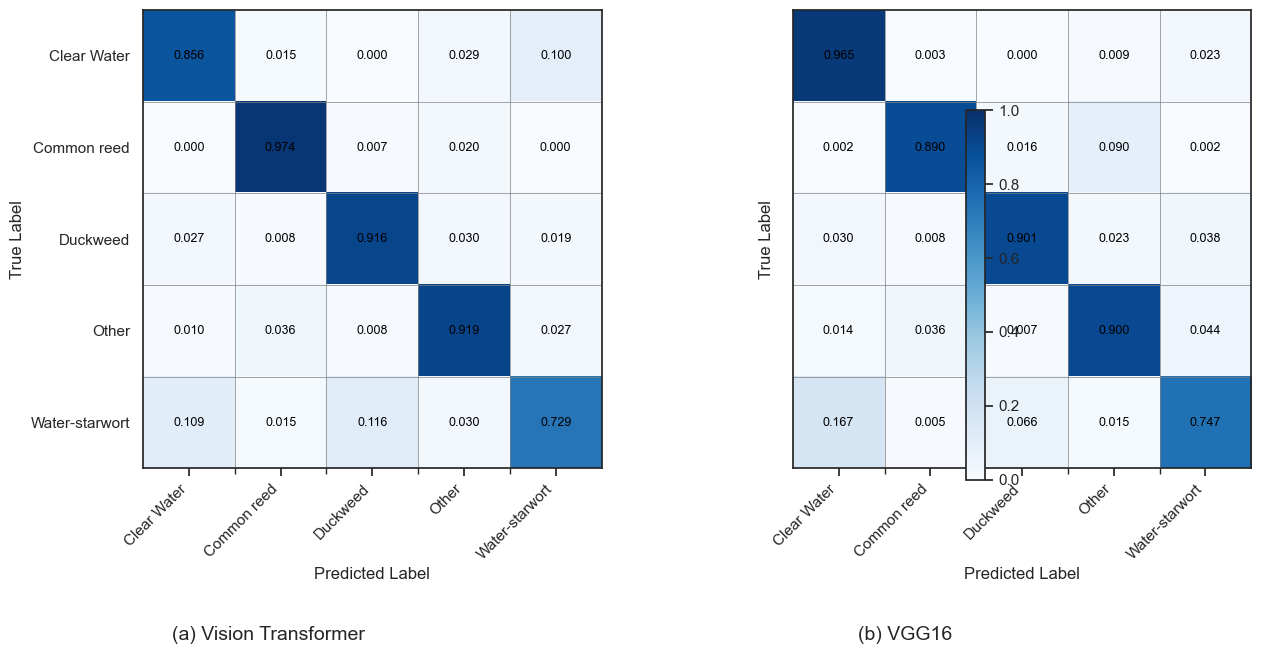

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# === 1. CONFIG PATHS ===
VGG_PRED_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\predictions_output_vgg16.csv"
VIT_PRED_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv"
output_path = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures\confusion_matrix_normalized_matshow_vit_vgg16.png"

# === 2. LOAD DATA ===
df_vgg = pd.read_csv(VGG_PRED_CSV)
df_vit = pd.read_csv(VIT_PRED_CSV)

# === 3. DETERMINE COMMON LABEL ORDER ===
labels = sorted(set(df_vgg['true_label']).union(df_vit['true_label']))

# === 4. COMPUTE NORMALIZED CONFUSION MATRICES ===
cm_vgg = confusion_matrix(df_vgg['true_label'], df_vgg['pred_label'], labels=labels, normalize='true')
cm_vit = confusion_matrix(df_vit['true_label'], df_vit['pred_label'], labels=labels, normalize='true')

# === 5. PLOT SIDE-BY-SIDE (Matshow Style with Grid & Floats) ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cmap = 'Blues'

# (a) ViT
im1 = ax1.matshow(cm_vit, cmap=cmap, vmin=0, vmax=1)
for i in range(cm_vit.shape[0]):
    for j in range(cm_vit.shape[1]):
        ax1.text(j, i, f"{cm_vit[i, j]:.3f}", va='center', ha='center', fontsize=9, color='black')

ax1.set_xticks(range(len(labels)))
ax1.set_yticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_yticklabels(labels)
ax1.set_xlabel("Predicted Label", fontsize=12)
ax1.set_ylabel("True Label", fontsize=12)

# Add grid lines between cells
ax1.set_xticks([x - 0.5 for x in range(1, len(labels))], minor=True)
ax1.set_yticks([y - 0.5 for y in range(1, len(labels))], minor=True)
ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(which='minor', bottom=False, left=False)
ax1.xaxis.set_ticks_position('bottom')
ax1.xaxis.set_label_position('bottom')

# (b) VGG16
im2 = ax2.matshow(cm_vgg, cmap=cmap, vmin=0, vmax=1)
for i in range(cm_vgg.shape[0]):
    for j in range(cm_vgg.shape[1]):
        ax2.text(j, i, f"{cm_vgg[i, j]:.3f}", va='center', ha='center', fontsize=9, color='black')

ax2.set_xticks(range(len(labels)))
ax2.set_yticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_yticklabels([])  # Hide y-tick labels for second plot
ax2.set_xlabel("Predicted Label", fontsize=12)
ax2.set_ylabel("True Label", fontsize=12)

ax2.set_xticks([x - 0.5 for x in range(1, len(labels))], minor=True)
ax2.set_yticks([y - 0.5 for y in range(1, len(labels))], minor=True)
ax2.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax2.tick_params(which='minor', bottom=False, left=False)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')

# Shared colorbar
fig.colorbar(im1, ax=[ax1, ax2], shrink=0.8, orientation='vertical', pad=0.02)

# Labels below
fig.text(0.285, -0.08, "(a) Vision Transformer", fontsize=14, ha='center')
fig.text(0.74, -0.08, "(b) VGG16", fontsize=14, ha='center')

# Save
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


## macro F1 by model and season

In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ─── 0. CONFIG ────────────────────────────────────────────────────────────────
results = {
    "VGG16": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_March\Results\vgg16\tree_classes\confidence_scores.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\confidence_scores.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\confidence_scores.csv",
    },
    "ViT": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_March\Results\ViT\predictions.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv",
    },
}

season_order = ["March", "July", "October"]
model_hue_order = ["ViT", "VGG16"]

# Custom warm-tone palette
palette = {
    "ViT": "#377eb8",
    "VGG16": "#4daf4a",
}

# Process data to compute macro F1
macro_rows = []
for model, seasons in results.items():
    for season, path in seasons.items():
        df = pd.read_csv(path)
        if model == "VGG16":
            y_true = df["true"]
            y_pred = df["pred"]
        else:
            y_true = df["true_label"]
            y_pred = df["pred_label"]
        present = sorted(y_true.unique())
        m = f1_score(y_true, y_pred, labels=present, average="macro")
        macro_rows.append({"Model": model, "Season": season, "Macro F1": m})

macro_df = pd.DataFrame(macro_rows)

# Create figure in Matplotlib style to match others
fig, ax = plt.subplots(figsize=(7, 5))
bar_width = 0.35
x = range(len(season_order))

# Offsets for grouped bars
offsets = {
    "ViT": [-bar_width/2],
    "VGG16": [bar_width/2]
}

# Draw bars manually
for model in model_hue_order:
    values = [macro_df[(macro_df["Model"] == model) & (macro_df["Season"] == season)]["Macro F1"].values[0]
              for season in season_order]
    positions = [i + offsets[model][0] for i in x]
    bars = ax.bar(positions, values, width=bar_width, label=model,
                  color=palette[model], edgecolor='black', linewidth=0.8)

# X-axis formatting
ax.set_xticks(x)
ax.set_xticklabels(season_order, fontsize=11)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Macro F1", fontsize=12, labelpad=10)
ax.set_xlabel("Season", fontsize=12, labelpad=10)

# Horizontal gridlines
ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Legend
ax.legend(title="", loc="upper left", fontsize=11, frameon=True)

plt.tight_layout()
output_path = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures\macro_f1_by_season_matplotlib_style.png"
plt.savefig(output_path, dpi=600, bbox_inches="tight")
plt.close()


In [26]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ─── 0. CONFIG ────────────────────────────────────────────────────────────────
results = {
    "VGG16": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_March\Results\vgg16\tree_classes\confidence_scores.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\confidence_scores.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\confidence_scores.csv",
    },
    "ViT": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_March\Results\ViT\predictions.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv",
    },
}

out_dir = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures"
os.makedirs(out_dir, exist_ok=True)

season_order = ["March", "July", "October"]
model_order = ["ViT", "VGG16"]

# warm‐tone palette
palette = {
    "ViT":   "#377eb8",   # orange
    "VGG16": "#4daf4a",   # red
}


# ─── 1. MACRO-F1 BAR CHART ─────────────────────────────────────────────────────
# Load and process data
delta_rows = []
for model, paths in results.items():
    dfj = pd.read_csv(paths["July"])
    dfo = pd.read_csv(paths["October"])
    if model == "VGG16":
        yj, pj = dfj["true"], dfj["pred"]
        yo, po = dfo["true"], dfo["pred"]
    else:
        yj, pj = dfj["true_label"], dfj["pred_label"]
        yo, po = dfo["true_label"], dfo["pred_label"]
    classes = sorted(set(yj) & set(yo))
    for cls in classes:
        f1_j = f1_score(yj, pj, labels=[cls], average="macro", zero_division=0)
        f1_o = f1_score(yo, po, labels=[cls], average="macro", zero_division=0)
        delta_rows.append({"Model": model, "Class": cls, "Delta F1": f1_o - f1_j})

delta_df = pd.DataFrame(delta_rows)

# Plot with matplotlib styling
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
classes = delta_df["Class"].unique()
x = range(len(classes))

for i, model in enumerate(model_order):
    subset = delta_df[delta_df["Model"] == model]
    offset = (i - 0.5) * bar_width
    ax.bar(
        [pos + offset for pos in x],
        subset["Delta F1"],
        width=bar_width,
        label=model,
        color=palette[model],
        edgecolor="black",
        linewidth=0.8
    )

ax.axhline(0, color="black", linestyle="--", linewidth=0.5) 
ax.set_ylabel("Δ F1 (October − July)", fontsize=12, labelpad=10)
ax.set_xlabel("Class", fontsize=12, labelpad=10)
ax.set_ylim(-0.4, 0.05)
ax.set_xticks(x)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=30)
ax.legend(title="", loc="lower left", fontsize=11, frameon=True)
#ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
ax.xaxis.grid(False)  # Disable x-axis grid
plt.tight_layout()

output_path = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures\delta_f1_per_class_final.png"
plt.savefig(output_path, dpi=600, bbox_inches="tight")
plt.close()



C:\Users\Sander\AppData\Local\Temp\ipykernel_17876\3519084653.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


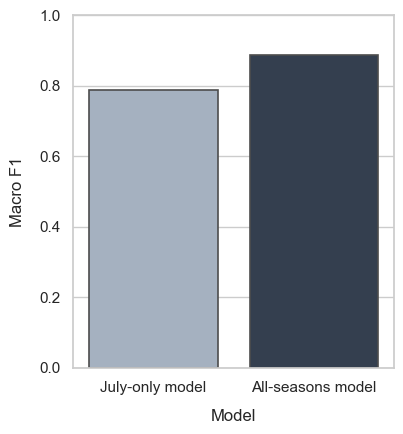

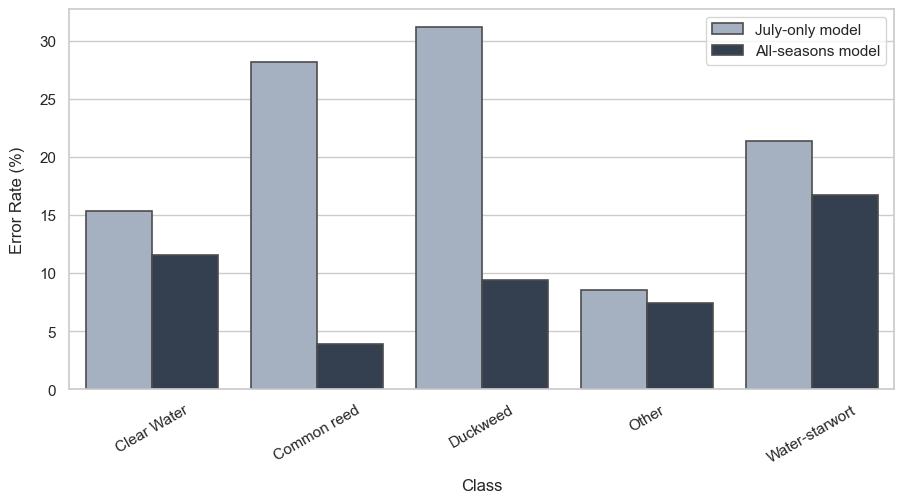

In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ─── 0. CONFIG ─────────────────────────────────────────────────────────────────
# Prediction CSVs must have columns: patch_filename, true_label, pred_label, confidence
models = {
    "July-only model": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_March\Results\ViT\predictions.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv",
    },
    "All-seasons model": {
        "March":   r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\all_seasons_model\test_data_pred\merged_March.csv",
        "July":    r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\all_seasons_model\test_data_pred\merged_July.csv",
        "October": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\all_seasons_model\test_data_pred\merged_October.csv",
    }
}

OUT_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures"
os.makedirs(OUT_DIR, exist_ok=True)



# ─── 1. MACRO-F1 PER SEASON ───────────────────────────────────────────────────
season_rows = []
for model_name, months in models.items():
    for season, csv_path in months.items():
        df = pd.read_csv(csv_path)
        m = f1_score(df["true_label"], df["pred_label"], average="macro")
        season_rows.append({
            "Model": model_name,
            "Season": season,
            "Macro F1": m
        })
season_df = pd.DataFrame(season_rows)

# ─── 2. OVERALL MACRO-F1 (ALL DATA COMBINED) ─────────────────────────────────
overall_rows = []
for model_name, months in models.items():
    parts = [pd.read_csv(p)[["true_label","pred_label"]] for p in months.values()]
    concat = pd.concat(parts, ignore_index=True)
    m_all = f1_score(concat["true_label"], concat["pred_label"], average="macro")
    overall_rows.append({"Model": model_name, "Macro F1": m_all})
overall_df = pd.DataFrame(overall_rows)

# ─── 3. ERROR RATE PER CLASS (ALL DATA COMBINED) ──────────────────────────────
error_rows = []
for model_name, months in models.items():
    parts = [pd.read_csv(p) for p in months.values()]
    df_all = pd.concat(parts, ignore_index=True)
    classes = sorted(df_all["true_label"].unique())
    for cls in classes:
        sub = df_all[df_all["true_label"] == cls]
        err = 100 * (1 - accuracy_score(sub["true_label"], sub["pred_label"]))
        error_rows.append({
            "Model": model_name,
            "Class": cls,
            "Error Rate (%)": err
        })
error_df = pd.DataFrame(error_rows)

# Professional palette
palette = {
    "July-only model": "#A0B1C5",      # softened muted blue
    "All-seasons model": "#2F3E54",   # dark steel blue
}

# Set style
sns.set_theme(style="whitegrid")

# ─── Macro F1 Overall ───
fig1, ax1 = plt.subplots(figsize=(4.2, 4.5))
sns.barplot(
    data=overall_df,
    x="Model", y="Macro F1",
    palette=palette,
    order=["July-only model", "All-seasons model"],
    ax=ax1, edgecolor=".3", linewidth=1.2
)
ax1.set_ylim(0, 1)
ax1.set_ylabel("Macro F1", fontsize=12, labelpad=10)
ax1.set_xlabel("Model", fontsize=12, labelpad=10)
ax1.tick_params(axis='x', labelsize=11)
ax1.tick_params(axis='y', labelsize=11)
ax1.set_title("")  # Removed
fig1.tight_layout()



# ─── Error Rate per Class ───
fig2, ax2 = plt.subplots(figsize=(9.2, 5.2))
sns.barplot(
    data=error_df,
    x="Class", y="Error Rate (%)", hue="Model",
    palette=palette,
    ax=ax2, edgecolor=".3", linewidth=1.2
)
ax2.set_ylabel("Error Rate (%)", fontsize=12, labelpad=10)
ax2.set_xlabel("Class", fontsize=12, labelpad=10)
ax2.set_title("")  # Removed
ax2.tick_params(axis='x', rotation=30, labelsize=11)
ax2.tick_params(axis='y', labelsize=11)
ax2.legend(title="", fontsize=11, loc="upper right", frameon=True)
fig2.tight_layout()

fig1.savefig(os.path.join(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures", "macro_f1_overall.png"), dpi=600, bbox_inches="tight")
fig2.savefig(os.path.join(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures", "error_rate_per_class.png"), dpi=600, bbox_inches="tight")



## effect of light condition

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Load data
input_csv = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\all_seasons_model\test_data_pred\all_seasons_full_predictions.csv"

df = pd.read_csv(input_csv)

# Ensure required columns are present
required_cols = {"true_label", "pred_label", "brightness_mean"}
assert required_cols.issubset(df.columns)

# Create output directory
output_dir = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures"
os.makedirs(output_dir, exist_ok=True)

# Color setup
sun_color = "#f1a226"
shadow_color = "#707070"
bar_color = "#384860"

# === 1. MISCLASSIFICATION RATE PER CLASS WITH BAR OUTLINES AND GRID LINES ABOVE ===
df["correct"] = df["true_label"] == df["pred_label"]

misrate = (
    df.assign(mis=lambda d: ~d["correct"])
      .groupby("true_label")
      .mis
      .mean()
      .mul(100)
      .reset_index(name="misclass_pct")
)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(misrate["true_label"], misrate["misclass_pct"],
              color="#384860", edgecolor='black', linewidth=1)

ax.set_xlabel("Class", fontsize=12, labelpad=10)
ax.set_ylabel("Misclassification Rate (%)", fontsize=12, labelpad=10)
ax.set_ylim(0, max(misrate["misclass_pct"]) + 5)

# Add horizontal grid lines that appear behind the bars
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
misclass_plot_path = os.path.join(output_dir, "misclassification_rate_by_class_v4.png")
plt.savefig(misclass_plot_path, dpi=300, bbox_inches="tight")
plt.close()

# === 2. PLAIN CONFUSION MATRIX WITH CELL OUTLINES ===
labels = sorted(df["true_label"].unique())
cm = confusion_matrix(df["true_label"], df["pred_label"], labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')

# Add counts in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), va='center', ha='center', fontsize=10, color='black')

# Set ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("True label", fontsize=12, labelpad=10)

# Add grid lines around cells
ax.set_xticks([x - 0.5 for x in range(1, len(labels))], minor=True)
ax.set_yticks([y - 0.5 for y in range(1, len(labels))], minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)
# Move x-axis labels to the bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar(cax)
plt.tight_layout()
conf_matrix_path = os.path.join(output_dir, "confusion_matrix_plain_v4.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.close()

misclass_plot_path, conf_matrix_path


('C:\\Users\\Sander\\OneDrive - UGent\\Semester_2\\Masterproef\\Overleaf\\Final_figures\\misclassification_rate_by_class_v4.png',
 'C:\\Users\\Sander\\OneDrive - UGent\\Semester_2\\Masterproef\\Overleaf\\Final_figures\\confusion_matrix_plain_v4.png')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Load data
input_csv = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\all_seasons_model\test_data_pred\all_seasons_full_predictions.csv"

df = pd.read_csv(input_csv)

# Ensure required columns are present
required_cols = {"true_label", "pred_label", "brightness_mean"}
assert required_cols.issubset(df.columns)

# Create output directory
output_dir = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Overleaf\Final_figures"
os.makedirs(output_dir, exist_ok=True)

# Color setup
sun_color = "#f1a226"
shadow_color = "#707070"
bar_color = "#384860"
# === 2. NORMALIZED CONFUSION MATRIX WITH DECIMAL VALUES AND CELL OUTLINES ===
labels = sorted(df["true_label"].unique())
cm = confusion_matrix(df["true_label"], df["pred_label"], labels=labels, normalize='true')

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')

# Add float values in cells (rounded to 3 decimal places)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:.3f}", va='center', ha='center', fontsize=10, color='black')

# Set ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("True label", fontsize=12, labelpad=10)

# Add grid lines around cells
ax.set_xticks([x - 0.5 for x in range(1, len(labels))], minor=True)
ax.set_yticks([y - 0.5 for y in range(1, len(labels))], minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

# Move x-axis labels to bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

plt.colorbar(cax)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_normalized_v4.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
plt.close()
